In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import squanch

from tensorflow.python.keras.optimizers import Adam, SGD
from tensorflow.python.keras import backend as K

K.set_floatx('float64')

from qpga import *

## NOON state preparation

In [2]:
N = 4
num_samples = 100

in_data = np_to_k_complex(np.array([zero_state(N)] * num_samples))
out_data = np_to_k_complex(np.array([noon_state(N)] * num_samples))

In [11]:
model = QPGA(N, 10*N).as_sequential()
model.compile(optimizer=Adam(lr=0.01), 
              loss=antifidelity, 
              metrics=[antifidelity])

callback = FrameWriterCallback(input_state = in_data[0:1], target_state = out_data[0:1])
reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
                                                       factor = 0.1,
                                                       patience = 2,
                                                       verbose=1,
                                                       min_lr=1e-6)
early_stop_callback = keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                    patience = 4,
                                                    verbose = 1,
                                                    restore_best_weights = True)

history = model.fit(in_data, out_data, epochs=100, 
                    batch_size = 1,
                    validation_split = 0.25,
                    callbacks=[callback, early_stop_callback, reduce_lr_callback], verbose = 2)

Train on 75 samples, validate on 25 samples
Epoch 1/100
75/75 - 43s - loss: 0.0521 - antifidelity: 1.2730e-04 - val_loss: 1.0152e-04 - val_antifidelity: 1.0152e-04
Epoch 2/100
75/75 - 8s - loss: 1.2676e-05 - antifidelity: 3.4567e-08 - val_loss: 4.1223e-08 - val_antifidelity: 4.1223e-08
Epoch 3/100
75/75 - 8s - loss: 5.7248e-09 - antifidelity: 1.8741e-11 - val_loss: 1.5195e-11 - val_antifidelity: 1.5195e-11
Epoch 4/100

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.001.
75/75 - 8s - loss: 2.3951e-12 - antifidelity: 6.5059e-14 - val_loss: 6.7502e-14 - val_antifidelity: 6.7502e-14
Epoch 5/100
75/75 - 8s - loss: 5.7880e-14 - antifidelity: 5.7732e-14 - val_loss: 5.5955e-14 - val_antifidelity: 5.5955e-14
Epoch 6/100

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0001.
75/75 - 7s - loss: 5.7169e-14 - antifidelity: 5.6843e-14 - val_loss: 6.0396e-14 - val_antifidelity: 6.0396e-14
Epoch 7/100
75/75 - 7s - loss: 5.6749e-14 - antifidelity: 5.6399e-14 - val_loss: 5.7288e-1

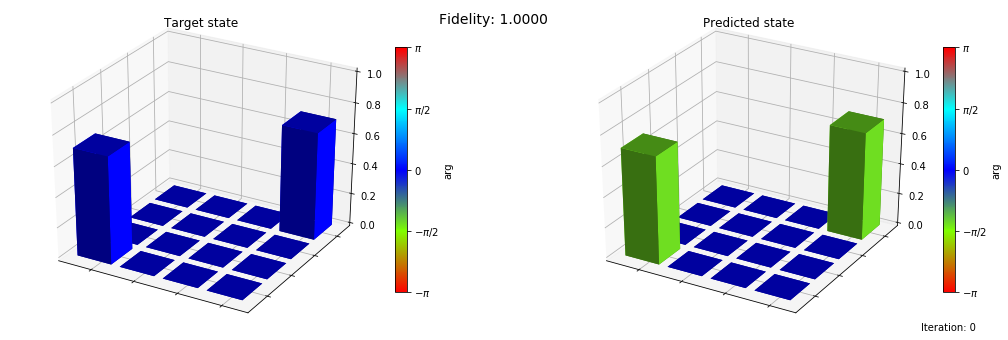

In [12]:
# plot_state_comparison(out_data[0:1], callback.predictions[-1], iteration=0, savefig=False)
plot_state_comparison(out_data[0:1], model.predict(in_data[0:1]), iteration=0)

## Implementing QFT

In [8]:
def QFT(qubits):
    '''Applies quantum Fourier transform to inputs'''
    N = len(qubits)
    for n in range(N, 0, -1):
        target = qubits[N - n]
        squanch.H(target)
        for m in range(1, n):
            squanch.CPHASE(qubits[N - n + m], target,2*np.pi/2**(m+1))
            
def QFT_layer_count(num_qubits, include_swap=True):
    '''
    Counts the number of layers (1 layer = single qubit + CZ) required to 
    implement the n-qubit quantum Fourier transform. If include_swap set to
    true, include gates to allow qubit A to talk to non-neighbor qubit B
    '''
    layers = 0
    can_concat_single_qubit_op = False
    for n in range(num_qubits, 0, -1):
        
        # Hadamard on target requires 1 single qubit layer
        if can_concat_single_qubit_op:
            layers -= 1
        layers += 1
        can_concat_single_qubit_op = True
        
        # If include swap, needs 3 layers per swap from qubit 0 to qubit m
        if include_swap:
            distance = n - 1
            if distance > 0:
                if can_concat_single_qubit_op:
                    layers -= 1 # first layer of swap can concat with previous H
                layers += 3 * distance
                can_concat_single_qubit_op = False # swap ends on CZ
                
        # Controlled-phase of 2pi / 2^m requires 2 layers
        if can_concat_single_qubit_op:
            layers -= 1
        layers += 2
        can_concat_single_qubit_op = True
        
        # Include swap gates back to original position
        if include_swap:
            distance = n - 1
            if distance > 0:
                if can_concat_single_qubit_op:
                    layers -= 1 # first layer of swap can concat with previous H
                layers += 3 * distance
                can_concat_single_qubit_op = False # swap ends on CZ
    
    # Return total count of layers
    return layers


In [3]:
in_data, out_data = prepare_training_data(QFT, 4, 10000)

### ML approach

In [14]:
QFT_layer_count(4, include_swap = True)

41

In [15]:
fidelities = fidelity_depth_search(list(range(2,20)),
                                   in_data = in_data,
                                   out_data = out_data,
                                   log_path = "./logs", 
                                   log_name = "QFT_fidelities.log",
                                   return_on_first_convergence = True)

Train on 7500 samples, validate on 2500 samples
Epoch 1/100
7500/7500 - 6s - loss: 0.6751 - antifidelity: 0.6751 - val_loss: 0.5729 - val_antifidelity: 0.5729
Epoch 2/100
7500/7500 - 2s - loss: 0.5743 - antifidelity: 0.5743 - val_loss: 0.5730 - val_antifidelity: 0.5730
Epoch 3/100


KeyboardInterrupt: 

In [16]:
learning_rate = 0.001 # 2**N * 0.001 
    
model = QPGA(N, 25*N).as_sequential()
model.compile(optimizer=Adam(lr=learning_rate), 
              loss=antifidelity, 
              metrics=[antifidelity, 'mse'])

callback = FrameWriterCallback(input_state = in_data[0:1], target_state = out_data[0:1])
history = model.fit(in_data, out_data, epochs=10, callbacks=[callback])

Epoch 1/10
10000/10000 [==============================] - 208s 21ms/step - loss: 0.1761 - antifidelity: 0.1761 - mean_squared_error: 0.0082
Epoch 2/10
10000/10000 [==============================] - 70s 7ms/step - loss: 2.5398e-05 - antifidelity: 2.5398e-05 - mean_squared_error: 5.9089e-04
Epoch 3/10
10000/10000 [==============================] - 70s 7ms/step - loss: 5.9583e-10 - antifidelity: 5.9583e-10 - mean_squared_error: 6.2580e-04
Epoch 4/10
10000/10000 [==============================] - 73s 7ms/step - loss: 1.4135e-13 - antifidelity: 1.4135e-13 - mean_squared_error: 6.2613e-04
Epoch 5/10
10000/10000 [==============================] - 71s 7ms/step - loss: 1.4187e-13 - antifidelity: 1.4187e-13 - mean_squared_error: 6.2613e-04
Epoch 6/10
10000/10000 [==============================] - 68s 7ms/step - loss: 1.4229e-13 - antifidelity: 1.4229e-13 - mean_squared_error: 6.2613e-04
Epoch 7/10
10000/10000 [==============================] - 69s 7ms/step - loss: 1.4257e-13 - antifidelity: 1.42

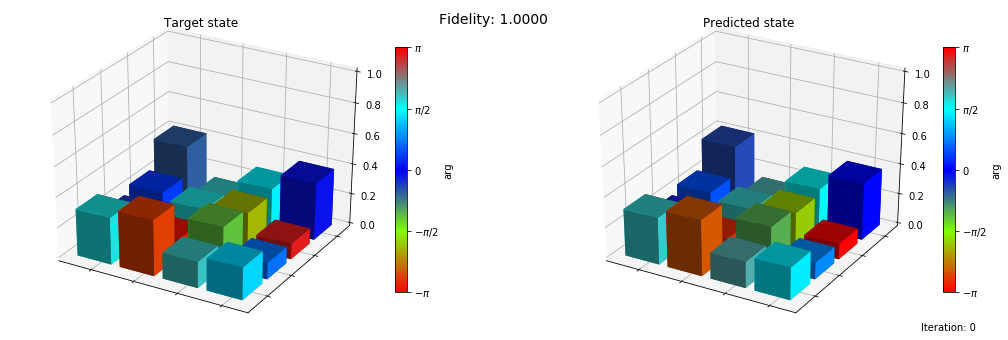

In [21]:
offset = 110
plot_state_comparison(out_data[offset+0:offset+1], model.predict(in_data[offset+0:offset+1]), iteration=0)

### Explicit decomposition

## Older stuff

In [ ]:
# for i, pred_state in enumerate(callback.predictions):
#     print("Saving frame {}/{}...".format(i, len(callback.predictions)))
#     plot_state_comparison(callback.predict_state, pred_state, iteration=i, savefig=True)
